In [2]:
import os

In [10]:
os.listdir("../results/boxing1")

['alphapose-results.json',
 'curvature_difference_animation.html',
 'curvature_video.mp4',
 'mesh.mp4',
 'mesh.npy',
 'X3D.mp4',
 'X3D.npy']

In [11]:
import numpy as np

mesh = np.load("../results/boxing1/X3D.npy")
mesh.shape

(664, 17, 3)

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class PoseDataset(Dataset):
    def __init__(self, file_path):
        self.mesh = np.load(file_path)  # (num_frames, num_joints, 3)
        self.num_frames = self.mesh.shape[0]

    def __len__(self):
        return self.num_frames - 1  # 마지막 프레임은 target이 없으므로 제외

    def __getitem__(self, idx):
        input_vector = self.mesh[idx]      # (17, 3)
        target_vector = self.mesh[idx + 1] # (17, 3)

        # NumPy 배열을 PyTorch Tensor로 변환
        input_vector = torch.tensor(input_vector, dtype=torch.float32)
        target_vector = torch.tensor(target_vector, dtype=torch.float32)

        return input_vector, target_vector

# 데이터셋 경로 설정
file_path = "../results/boxing1/X3D.npy"

# 데이터셋 및 데이터로더 생성
dataset = PoseDataset(file_path)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 데이터 확인
for input_vector, target_vector in dataloader:
    print("Input Shape:", input_vector.shape)   # (batch_size, 17, 3)
    print("Target Shape:", target_vector.shape) # (batch_size, 17, 3)
    break


Input Shape: torch.Size([4, 17, 3])
Target Shape: torch.Size([4, 17, 3])


In [19]:
import torch
import torch.nn as nn

class PoseMLP(nn.Module):
    def __init__(self, input_dim=17*3, hidden_dim=128, output_dim=17*3):
        super(PoseMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # (batch_size, 17*3)
        x = self.model(x)
        x = x.view(x.shape[0], 17, 3)  # (batch_size, 17, 3)
        return x

# 모델 생성
model = PoseMLP()
print(model)

# 테스트 입력
dummy_input = torch.randn(32, 17, 3)  # (batch_size, num_joints, 3)
output = model(dummy_input)
print("Output shape:", output.shape)  # 예상: (32, 17, 3)


PoseMLP(
  (model): Sequential(
    (0): Linear(in_features=51, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=51, bias=True)
  )
)
Output shape: torch.Size([32, 17, 3])


In [21]:
import torch.optim as optim

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 25  # 원하는 에포크 수 설정
for epoch in range(num_epochs):
    total_loss = 0.0

    for input_vector, target_vector in dataloader:
        optimizer.zero_grad()  # 기울기 초기화

        outputs = model(input_vector)  # 예측값
        loss = criterion(outputs, target_vector)  # MSE 손실 계산

        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")


Epoch [1/25], Loss: 0.000572
Epoch [2/25], Loss: 0.000569
Epoch [3/25], Loss: 0.000555
Epoch [4/25], Loss: 0.000507
Epoch [5/25], Loss: 0.000552
Epoch [6/25], Loss: 0.000572
Epoch [7/25], Loss: 0.000581
Epoch [8/25], Loss: 0.000528
Epoch [9/25], Loss: 0.000504
Epoch [10/25], Loss: 0.000563
Epoch [11/25], Loss: 0.000566
Epoch [12/25], Loss: 0.000500
Epoch [13/25], Loss: 0.000517
Epoch [14/25], Loss: 0.000531
Epoch [15/25], Loss: 0.000536
Epoch [16/25], Loss: 0.000517
Epoch [17/25], Loss: 0.000502
Epoch [18/25], Loss: 0.000503
Epoch [19/25], Loss: 0.000475
Epoch [20/25], Loss: 0.000519
Epoch [21/25], Loss: 0.000618
Epoch [22/25], Loss: 0.000499
Epoch [23/25], Loss: 0.000502
Epoch [24/25], Loss: 0.000489
Epoch [25/25], Loss: 0.000475


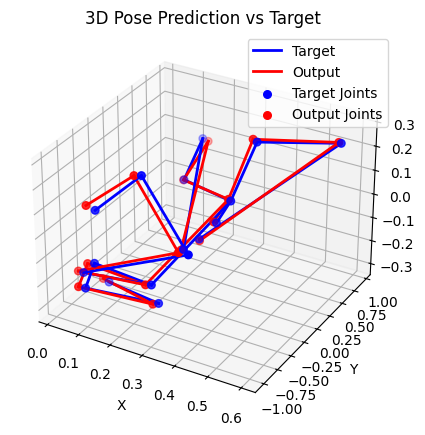

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 데이터 로딩
input_vector, target_vector = next(iter(dataloader))  # 첫 번째 배치 가져오기
outputs = model(input_vector)  # 모델 예측

# 첫 번째 샘플 선택 (batch_size 중 하나만 시각화)
target_sample = target_vector[0].detach().numpy()  # (17, 3)
output_sample = outputs[0].detach().numpy()  # (17, 3)

# 관절 연결 순서 (limbSeq)
limbSeq = [[0, 1], [1, 2], [1, 5], [1, 8], [2, 3], [3, 4], [5, 6], [6, 7],
           [8, 9], [8, 13], [9, 10], [10, 11], [11, 12], [13, 14], [14, 15], [15, 16]]

# 3D 플롯 설정
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# 타겟 데이터(파란색)와 예측 데이터(빨간색) 각각 플롯
for joint1, joint2 in limbSeq:
    # Target (ground truth)
    x_t, y_t, z_t = target_sample[joint1]
    x_t2, y_t2, z_t2 = target_sample[joint2]
    ax.plot([x_t, x_t2], [y_t, y_t2], [z_t, z_t2], 'b-', linewidth=2, label="Target" if joint1 == 0 else "")

    # Output (prediction)
    x_o, y_o, z_o = output_sample[joint1]
    x_o2, y_o2, z_o2 = output_sample[joint2]
    ax.plot([x_o, x_o2], [y_o, y_o2], [z_o, z_o2], 'r-', linewidth=2, label="Output" if joint1 == 0 else "")

# 관절 점 플롯 (파란색: 타겟, 빨간색: 출력)
ax.scatter(target_sample[:, 0], target_sample[:, 1], target_sample[:, 2], color='blue', label="Target Joints", s=30)
ax.scatter(output_sample[:, 0], output_sample[:, 1], output_sample[:, 2], color='red', label="Output Joints", s=30)

# 그래프 설정
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Pose Prediction vs Target")
ax.legend()

plt.show()
